<a href="https://colab.research.google.com/github/data-alch3m1st/ML_Tinkering_Python/blob/main/Copy_of_NLP_Tinkering_w_TFIDF_SMOTE_MultiModel_Spam_Classification_(imbalanced_dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### NLP with spaCy on an imbalanced dataset ###

To implement a **multi-model approach** for imbalanced data while incorporating techniques to address class imbalance (e.g., `class_weight='balanced'`, SMOTE). The workflow involves:

1. Initializing multiple models for comparison.
2. Evaluating each model using cross-validation to find the best-performing model.
3. Fine-tuning the best model using a grid search to find the optimal hyperparameters.

In [23]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
# import spacy


from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV
)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    classification_report, accuracy_score
    , confusion_matrix, ConfusionMatrixDisplay
)

# Note: be prepared for a metric ton of dependancy issues with imblearn (also, need to # !pip install imbalanced-learn)
# Given the dependancy issues and my own laziness and unwillingness to scale back sklearn, I used Colab (many folks will prob have to do the same...¯\_(ツ)_/¯)
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE


import warnings
warnings.simplefilter('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [24]:
# Load the dataset from GitHub
url = "https://raw.githubusercontent.com/mohitgupta-1O1/Kaggle-SMS-Spam-Collection-Dataset-/9823a7f115df8caa24f7b3adfcc770526fbd07e3/spam.csv"

df = pd.read_csv(url, encoding='latin-1')

df = df.rename(columns={'v1': 'label', 'v2': 'message'})
df = df[['label', 'message']]  # Keep only necessary columns

In [25]:
df.shape
df.head()
df.info()

(5572, 2)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [26]:
# Encode labels (spam: 1, ham: 0)
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

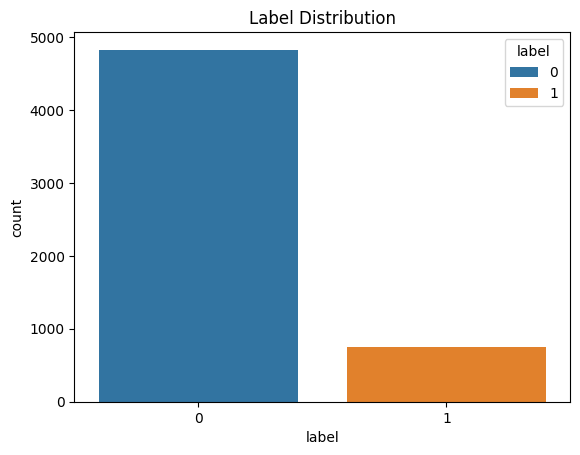

In [27]:
# Visualize label distribution
# Note: you will see this is an EXTREMELY imbalanced dataset ('spam' is ~13.4%)

sns.countplot(
    x='label', data=df, hue='label'
)
plt.title("Label Distribution")
plt.show();

In [28]:
X = df['message']
y = df['label']

X.shape, y.shape

((5572,), (5572,))

In [29]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=27
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4457,), (1115,), (4457,), (1115,))

In [30]:
# Initialize models for comparison
models = {
    'MultinomialNB': MultinomialNB()
    , 'LogisticRegression': LogisticRegression(max_iter=1000, random_state=27, class_weight='balanced')
    , 'SVC': SVC(random_state=27, class_weight='balanced') # Adjust for imbalance
    , 'LinearSVC': LinearSVC(max_iter=1000, random_state=27, class_weight='balanced')  # Adjust for imbalance
}

In [31]:
# Vectorize text data using TfidfVectorizer (* with spaCy_tokenizer;)
tfidf = TfidfVectorizer(
    # tokenizer=spacy_tokenizer, lowercase=True
    stop_words='english'
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [32]:
X_train_tfidf.shape, X_test_tfidf.shape

X_train_tfidf

((4457, 7408), (1115, 7408))

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 34687 stored elements and shape (4457, 7408)>

In [33]:
# Apply SMOTE to balance classes in the training set only
smote = SMOTE(
    random_state=27
)
X_train_tfidf_sm, y_train_sm = smote.fit_resample(X_train_tfidf, y_train)

X_train_tfidf_sm.shape, y_train_sm.shape

((7736, 7408), (7736,))

In [34]:
# Initialize models for comparison
models = {
    'MultinomialNB': MultinomialNB(),
    'LogisticRegression': LogisticRegression(
        max_iter=1000, random_state=27
    ),
    'SVC': SVC(random_state=27),
    'LinearSVC': LinearSVC(
        max_iter=1000, random_state=27
    )
}

In [35]:
# Evaluate models
for name, model in models.items():

    model.fit(X_train_tfidf_sm, y_train_sm)

    y_pred = model.predict(X_test_tfidf)

    accuracy = accuracy_score(y_test, y_pred)

    print(f"{name} Accuracy: {accuracy:.4f}")

MultinomialNB()

MultinomialNB Accuracy: 0.9749


LogisticRegression(max_iter=1000, random_state=27)

LogisticRegression Accuracy: 0.9785


SVC(random_state=27)

SVC Accuracy: 0.9803


LinearSVC(random_state=27)

LinearSVC Accuracy: 0.9857


In [36]:
# Select a base model (e.g., MultinomialNB) for hyperparameter tuning
base_model = LinearSVC(
    max_iter=1000, random_state=27
)

In [37]:
# Set up hyperparameter grid for GridSearchCV
param_grid = {
    'C': np.logspace(-2,2,17)
    , 'penalty': ['l2']  # 'l1' only works with 'liblinear' solver and 'dual=False'
    , 'loss': ['hinge', 'squared_hinge']
    , 'dual': ["auto"]  # For penalty='l2' and loss='squared_hinge', dual can be True or False
    , 'tol': [1e-4, 1e-3, 1e-2]
}

# Perform GridSearchCV
grid_search = GridSearchCV(
    base_model
    , param_grid
    , cv=5
    , scoring='accuracy'
)

grid_search.fit(X_train_tfidf_sm, y_train_sm)

GridSearchCV(cv=5, estimator=LinearSVC(random_state=27),
             param_grid={'C': array([1.00000000e-02, 1.77827941e-02, 3.16227766e-02, 5.62341325e-02,
       1.00000000e-01, 1.77827941e-01, 3.16227766e-01, 5.62341325e-01,
       1.00000000e+00, 1.77827941e+00, 3.16227766e+00, 5.62341325e+00,
       1.00000000e+01, 1.77827941e+01, 3.16227766e+01, 5.62341325e+01,
       1.00000000e+02]),
                         'dual': ['auto'], 'loss': ['hinge', 'squared_hinge'],
                         'penalty': ['l2'], 'tol': [0.0001, 0.001, 0.01]},
             scoring='accuracy')

In [38]:
# Print best hyperparameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Best Parameters: {'C': np.float64(10.0), 'dual': 'auto', 'loss': 'squared_hinge', 'penalty': 'l2', 'tol': 0.0001}
Best Cross-Validation Accuracy: 0.9996122360691444


In [39]:
# Evaluate best model on test data
best_model = grid_search.best_estimator_

# Now FIT the best_model (MUST DO BEFORE PREDICTING!!! {otherwise, you essentially reset the model! :o })
best_model.fit(X_train_tfidf_sm, y_train_sm)

LinearSVC(C=np.float64(10.0), random_state=27)

In [40]:
y_test_pred = best_model.predict(X_test_tfidf)

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
confusion_matrix(y_test, y_test_pred)
print(classification_report(y_test, y_test_pred))

Test Accuracy: 0.9811659192825112


array([[953,   4],
       [ 17, 141]])

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       957
           1       0.97      0.89      0.93       158

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



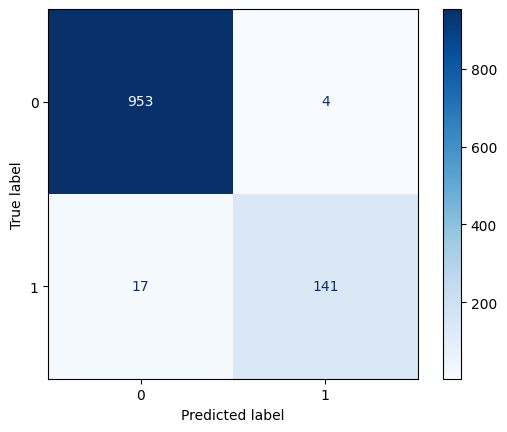

In [41]:
ConfusionMatrixDisplay.from_estimator(
    best_model, X_test_tfidf, y_test
    , cmap='Blues'
);

In [42]:
# Build a pipeline for testing on sample strings
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        stop_words='english'
        ))
    , ('model', best_model)
])

In [43]:
# HAVE TO FIT THE PIPES!!!

# Since the model is already trained, can fit directly to X, y;

pipeline.fit(X, y)

Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('model', LinearSVC(C=np.float64(10.0), random_state=27))])

In [44]:
# Test pipeline on sample strings
sample_strings = [
    "Congratulations! You've won a free ticket to Bahamas.",
    "Hey, are we still on for lunch tomorrow?",
    "Urgent! Your account has been compromised. Click this link.",
    "Congratulations son! Your Mother is so proud!",
    "Enlarge your portfolio 1000% with my proven investment secrets!",
    "We should link up tomorrow!",
    "This airline sucks!"
]

predictions = pipeline.predict(sample_strings)

# Display predictions
for text, label in zip(sample_strings, predictions):
    print(f"Message: {text} -> Prediction: {'Spam' if label == 1 else 'Ham'}\n")

Message: Congratulations! You've won a free ticket to Bahamas. -> Prediction: Ham

Message: Hey, are we still on for lunch tomorrow? -> Prediction: Ham

Message: Urgent! Your account has been compromised. Click this link. -> Prediction: Spam

Message: Congratulations son! Your Mother is so proud! -> Prediction: Ham

Message: Enlarge your portfolio 1000% with my proven investment secrets! -> Prediction: Ham

Message: We should link up tomorrow! -> Prediction: Ham

Message: This airline sucks! -> Prediction: Ham



In [ ]:
# Results from TFIDF stopwords='english' (NOT spaCy) ^^^ above essentially got 100% my sample unseen docs;


# Results from spaCy (one misclassification):
'''
Message: Congratulations! You've won a free ticket to Bahamas. -> Prediction: Spam

Message: Hey, are we still on for lunch tomorrow? -> Prediction: Ham

Message: Urgent! Your account has been compromised. Click this link. -> Prediction: Spam

Message: Congratulations son! Your Mother is so proud! -> Prediction: Ham

Message: Enlarge your portfolio 1000% with my proven investment secrets! -> Prediction: Spam

Message: We should link up tomorrow! -> Prediction: Ham

Message: This airline sucks! -> Prediction: Ham
'''

In [46]:
X_test_tfidf.shape

(1115, 7408)

In [47]:
base_model

LinearSVC(random_state=27)

In [48]:
best_model

LinearSVC(C=np.float64(10.0), random_state=27)